# Neural Networks and Deep Learning

**Homework 1 - Classification task**

**Academic Year 2021/2022**
**Dr. Alberto Testolin, Dr. Umberto Michieli**

**Capettini Croatto Hilario**

## General overview

**Explain it**

# Convolutional Autoencoder

An autoencoder, in general, is a network that is trained to attempt to copy its input to its output. Internally, it has a **latent space** that describes a code used to represent the input. The network may be viewed as consisting of two parts: an **encoder** function $h=f(x)$ and a **decoder** that produces a reconstruction $r=g(h)$.

![LALA](Img/autoencoder.png)

In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn

#For Optuna (Hyperparameters search)
import optuna
from optuna.integration import PyTorchLightningPruningCallback

C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set seeds for reproducibility (PyTorch, Python, Numpy)
matricola = 2013031
torch.manual_seed(matricola)
random.seed(matricola)
np.random.seed(matricola)

In [3]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cpu


### Dataset

In [4]:
### Download the data and create dataset
data_dir = 'dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=False)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=False)

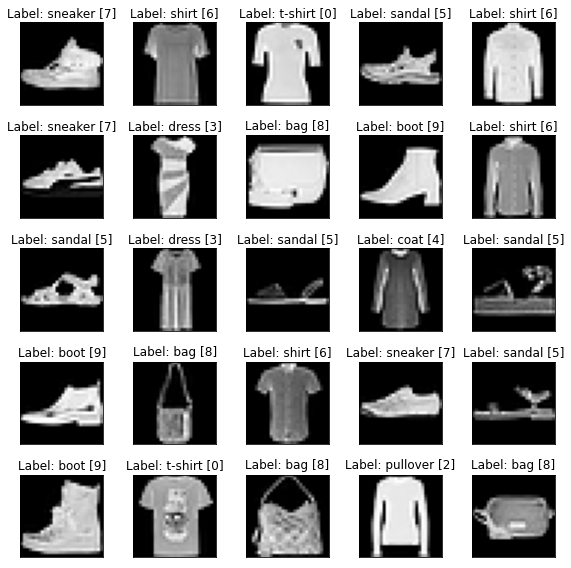

In [5]:
### Plot some sample
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title(f'Label: {label_names[label]} [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [6]:
# In this case the train_transform and test_transform are the same, 
# but we keep them separate for potential future updates
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])


In [7]:
# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform


In [8]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)


batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")


TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


### Architecture

![Encoder architecture](Img/encoder.png)

In [9]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, 
                      stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features= (32 * 3* 3), out_features=64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=64, out_features=encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

![](Img/decoder.png)

In [10]:
class Decoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=encoded_space_dim, out_features=64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=64, out_features=(32*3*3)),
            nn.ReLU(True)
        )
        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, 
                               stride=2, padding =0, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, 
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, 
                               stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

### Training

In [13]:
### Training function
def train_epoch(encoder, decoder, device,dataloader, loss_fn, optimizer):
    """
    This function train the network for one epoch
    """
    # Set train mode for both networks
    encoder.train()
    decoder.train()
    
    # Train
    train_loss = []
    for sample_batched, _ in dataloader:
        # Move data to device
        sample_batched = sample_batched.to(device)
        # Encode the data
        encoded_sample = encoder(sample_batched)
        # Decode the data
        decoded_sample = decoder(encoded_sample)
        # Compute loss
        loss = loss_fn(decoded_sample, sample_batched)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        #Updata weights
        optimizer.step()
        #Save trai loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)
    #Save the average train loss
    train_loss = np.mean(train_loss)
    print(f"AVERAGE TRAIN LOSS: {train_loss}")
    
    return train_loss

### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    """
    This function test the network performance for one epoch of training
    """
    # Set evaluation mode for both networks
    encoder.eval()
    decoder.eval()
    #
    test_loss = []
    # Discable gradient tracking
    with torch.no_grad():
        for sample_batched, _ in dataloader:
            # Move data to device
            sample_batched = sample_batched.to(device)
            # Encode the data
            encoded_sample = encoder(sample_batched)
            # Decode the data
            decoded_sample = decoder(encoded_sample)
            # Compute loss
            loss = loss_fn(decoded_sample, sample_batched)
             #Save test loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            test_loss.append(loss_batch)
        #Save the average train loss
        test_loss = np.mean(test_loss)
        print(f"AVERAGE TEST LOSS: {test_loss}")
    
    return test_loss
        

In [17]:
def plot_progress(encoder, decoder,test_dataset,epoch,keep =False):
    """
    This function plot the image we send to the autoencoder and the one returned by the
    network.
    """
    categories = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
    elements = [0,1,5,37]
    
    encoder.eval()
    decoder.eval()
    fig, axs = plt.subplots(2, 4, figsize=(12,6))
    fig.suptitle('Original images and reconstructed image (EPOCH %d)' % (epoch + 1),fontsize=15)
    fig.subplots_adjust(top=0.88)
    axs = axs.ravel()
    for i in range (4):
        img, label = test_dataset[elements[i]][0].unsqueeze(0).to(device),test_dataset[elements[i]][1]
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        # Plot the reconstructed image  
        axs[i].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[i].set_title(categories[label])
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i+4].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[i+4].set_title('Reconstructed image')
        axs[i+4].set_xticks([])
        axs[i+4].set_yticks([])
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)
    # Save figures
    if keep:
        os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
        fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
    plt.show()
    plt.close()

In [18]:
def training_cycle(encoder,decoder,device,training_data, test_data, loss_fn, optim,num_epochs,test_dataset,plot = False):
    """
    This function train the network for a desired number of epochs it also test the network 
    reconstruction performance and make plots comparing the input image and the reconstructed one.
    """
    #I keep track of losses for plots
    train_loss = []
    test_loss  = []
    for epoch in range(num_epochs):
        print('EPOCH %d/%d' % (epoch + 1, num_epochs))
        ### Training (use the training function)
        tr_l = train_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=training_data, 
            loss_fn=loss_fn, 
            optimizer=optim)
        train_loss.append(tr_l)
        ### Validation  (use the testing function)
        t_l = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=test_data, 
            loss_fn=loss_fn)
        test_loss.append(t_l)
        # Print Validationloss
        #print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, t_l))
        
        ### Plot progress
        if plot: plot_progress(encoder, decoder,test_dataset,epoch,keep = False)
        #Save network parameters
        torch.save(encoder.state_dict(), 'encoder_params.pth')
        torch.save(decoder.state_dict(), 'decoder_params.pth')
    return train_loss, test_loss

## Hyperparameter optimization

The hyperparameter optimization will be performed using Optuna

In [29]:
def objective(trial):
    max_epochs = 5
    
    # Parameters for the search
    encoded_space_dim      = trial.suggest_categorical("encoded_space_dim", [2,10])
    optimizer_name         = trial.suggest_categorical('optimizer_name',["SGD", "Adam"])
    lr                     = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    
    
    
    ### Initialize both networks
    encoder = Encoder(encoded_space_dim=encoded_space_dim)
    decoder = Decoder(encoded_space_dim=encoded_space_dim)
    
    ### Define the complete model
    model = nn.Sequential(encoder, decoder)
    model = model.to(device)
    
    
    ### Define the loss function
    loss_fn = torch.nn.MSELoss()
    
    
    #Define the optimizer
    optimizer = getattr(torch.optim,optimizer_name)(model.parameters(), lr=lr)

    ################################################################################################
    # Train a model (cant use the function because I would need the separated parts encoder decoder)
    for epoch in range(max_epochs):
        print('EPOCH %d/%d' % (epoch + 1, max_epochs))
        ### Training (use the training function)
        # Set train mode for both networks
        model.train()  
        train_loss = []
        
        # Train
        for sample_batched, _ in train_dataloader:
            # Move data to device
            sample_batched = sample_batched.to(device)
            # Encode decode the data
            encoded_decoded_sample = model(sample_batched)
            loss = loss_fn(encoded_decoded_sample, sample_batched)
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            #Updata weights
            optimizer.step()
            #Save trai loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)
        #Save the average train loss
        train_loss = np.mean(train_loss)
        print(f"AVERAGE TRAIN LOSS: {train_loss}")
   
        ### Validation  (use the testing function)
        # Set evaluation mode for both networks
        model.eval()
        test_loss = []
        # Discable gradient tracking
        with torch.no_grad():
            for sample_batched, _ in test_dataloader:
                # Move data to device
                sample_batched = sample_batched.to(device)
                # Encode decode the data
                encoded_decoded_sample = model(sample_batched)
                # Compute loss
                loss = loss_fn(encoded_decoded_sample, sample_batched)
                 #Save test loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                test_loss.append(loss_batch)
            #Save the average train loss
            test_loss = np.mean(test_loss)
            print(f"AVERAGE TEST LOSS: {test_loss}")    
    
    
    return test_loss


In [30]:
#Define the study
study = optuna.create_study(study_name="myfirstoptimizationstudy", direction="minimize")
study.optimize(objective, n_trials=10, timeout=30) #six hours

[I 2022-06-28 22:21:26,254] A new study created in memory with name: myfirstoptimizationstudy


EPOCH 1/5
AVERAGE TRAIN LOSS: 0.1690908968448639
AVERAGE TEST LOSS: 0.12810468673706055
EPOCH 2/5
AVERAGE TRAIN LOSS: 0.10332774370908737
AVERAGE TEST LOSS: 0.0912659540772438
EPOCH 3/5
AVERAGE TRAIN LOSS: 0.08644992113113403
AVERAGE TEST LOSS: 0.082321897149086
EPOCH 4/5
AVERAGE TRAIN LOSS: 0.07915614545345306
AVERAGE TEST LOSS: 0.07251174747943878
EPOCH 5/5
AVERAGE TRAIN LOSS: 0.06545952707529068


[I 2022-06-28 22:23:49,166] Trial 0 finished with value: 0.06003568321466446 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 7.895056808920034e-05}. Best is trial 0 with value: 0.06003568321466446.


AVERAGE TEST LOSS: 0.06003568321466446


In [31]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 1
Best trial:
  Value: 0.06003568321466446
  Params: 
    encoded_space_dim: 10
    optimizer_name: Adam
    lr: 7.895056808920034e-05


In [22]:
optuna.visualization.plot_param_importances(study)

In [23]:
optuna.visualization.plot_contour(study, params=['lr','encoded_space_dim'])

### Network Analysis

First we retrain the model using the best parameters

In [23]:
### Initialize both networks
encoded_space_dim = 2 #trial.params['encoded_space_dim']
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

EPOCH 1/40
AVERAGE TRAIN LOSS: 0.08357387781143188
AVERAGE TEST LOSS: 0.04381852224469185


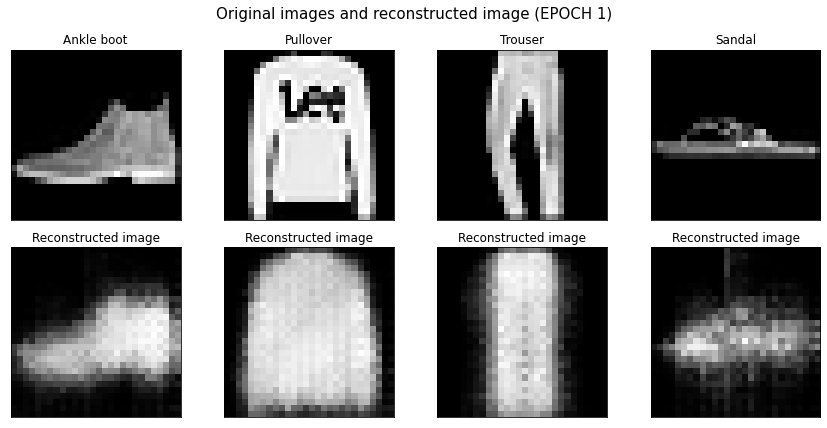

EPOCH 2/40
AVERAGE TRAIN LOSS: 0.04108449071645737
AVERAGE TEST LOSS: 0.04000585153698921


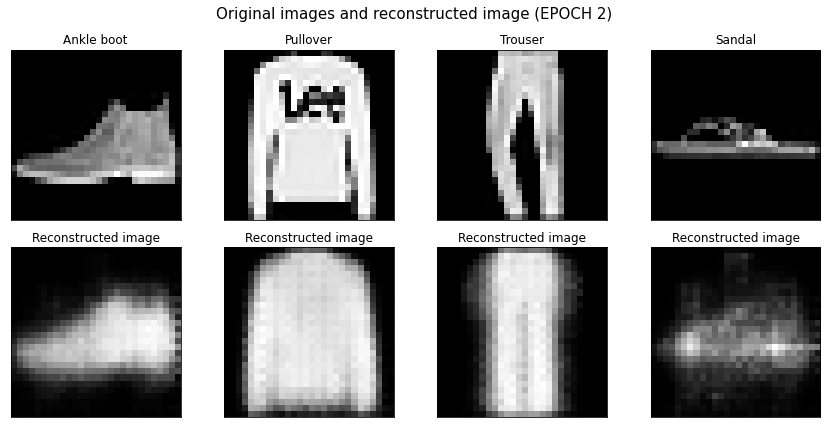

EPOCH 3/40
AVERAGE TRAIN LOSS: 0.03788384422659874
AVERAGE TEST LOSS: 0.03696102276444435


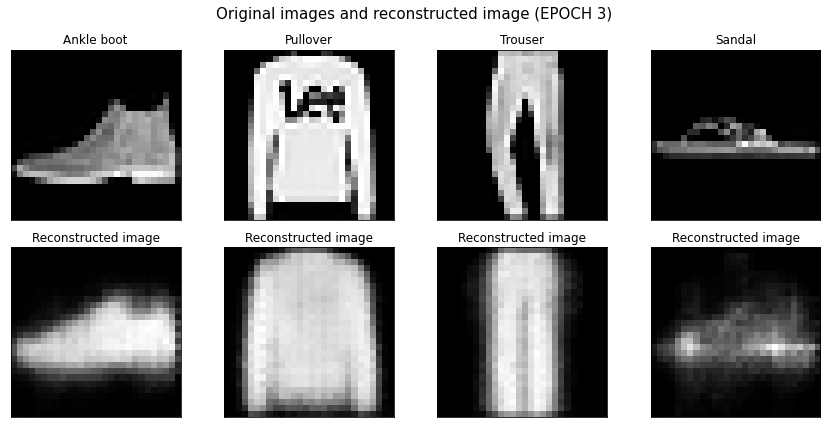

EPOCH 4/40
AVERAGE TRAIN LOSS: 0.035642657428979874
AVERAGE TEST LOSS: 0.03497800976037979


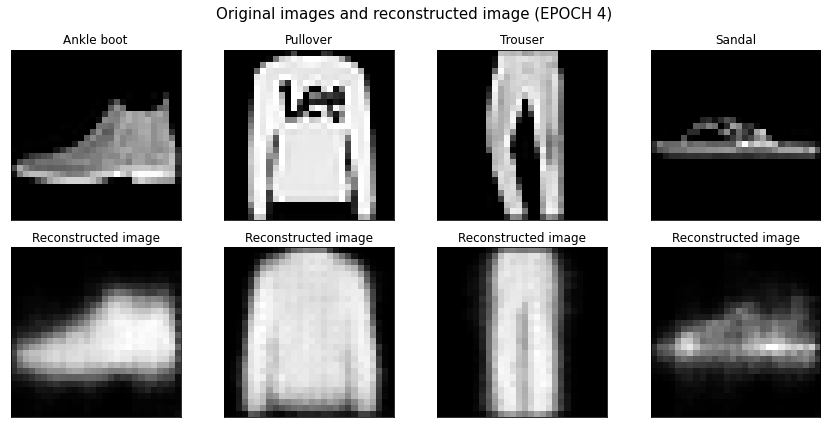

EPOCH 5/40
AVERAGE TRAIN LOSS: 0.034042876213788986
AVERAGE TEST LOSS: 0.03341028839349747


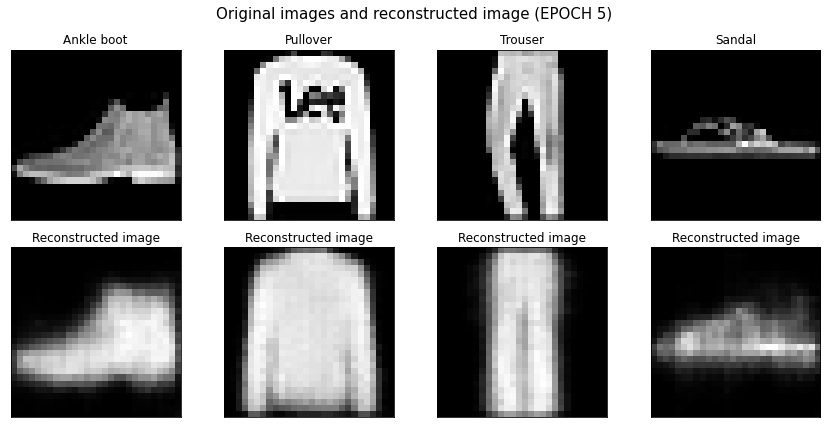

EPOCH 6/40
AVERAGE TRAIN LOSS: 0.032871026545763016
AVERAGE TEST LOSS: 0.03261362761259079


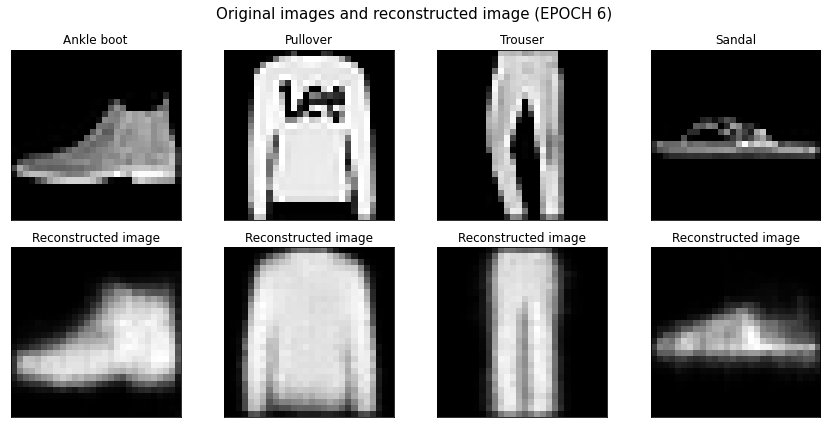

EPOCH 7/40
AVERAGE TRAIN LOSS: 0.032019536942243576
AVERAGE TEST LOSS: 0.03188330680131912


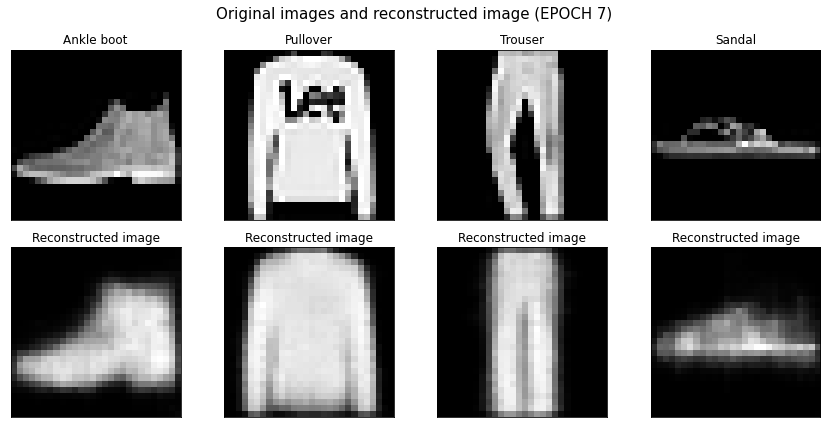

EPOCH 8/40
AVERAGE TRAIN LOSS: 0.03148921951651573
AVERAGE TEST LOSS: 0.03139321878552437


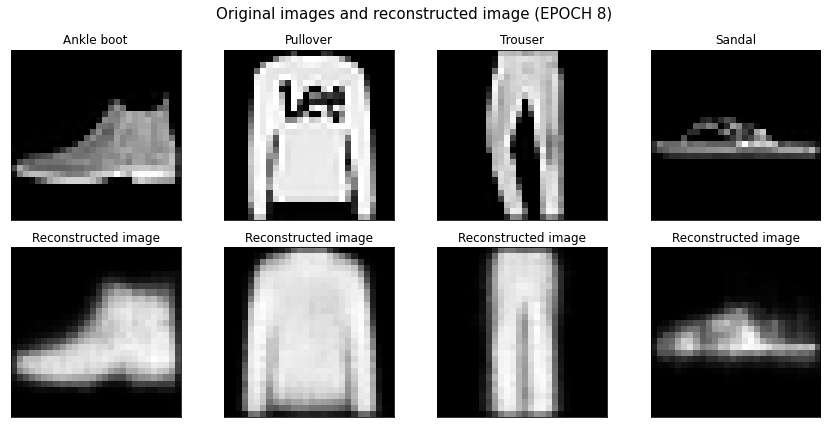

EPOCH 9/40
AVERAGE TRAIN LOSS: 0.03099570982158184
AVERAGE TEST LOSS: 0.030948031693696976


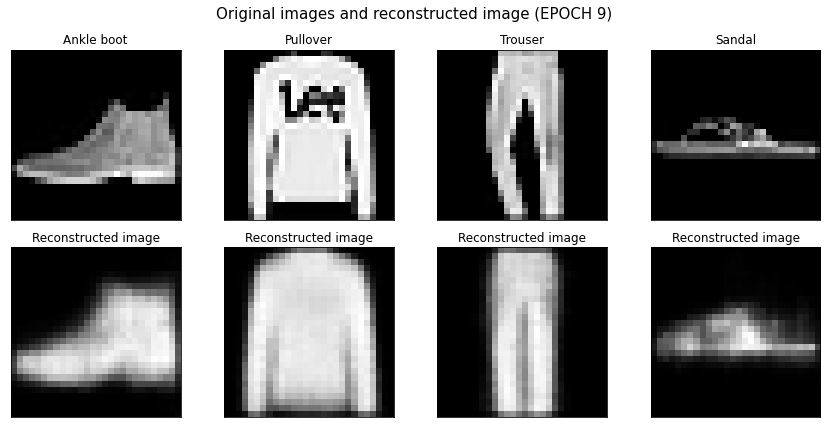

EPOCH 10/40
AVERAGE TRAIN LOSS: 0.030666403472423553
AVERAGE TEST LOSS: 0.030841493979096413


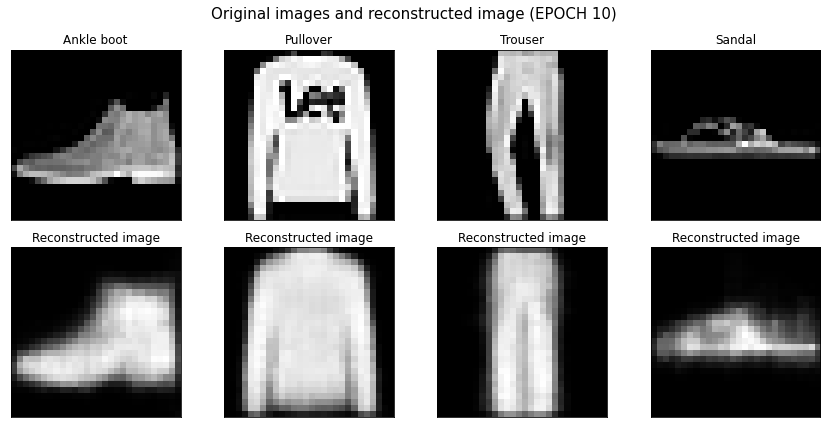

EPOCH 11/40
AVERAGE TRAIN LOSS: 0.03039672039449215
AVERAGE TEST LOSS: 0.030348319560289383


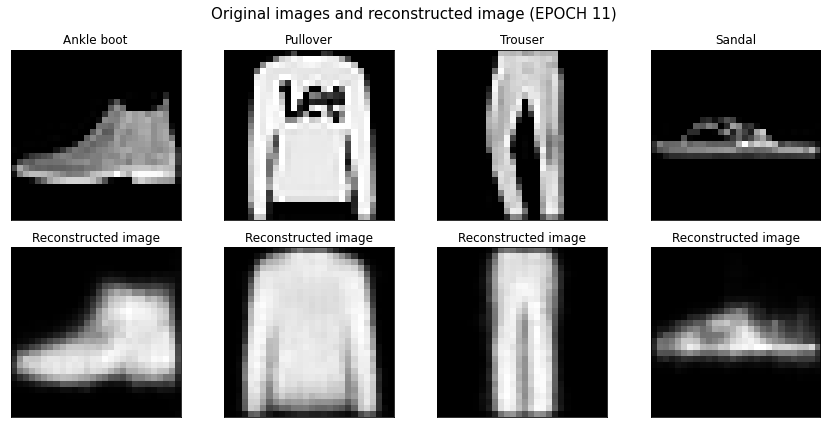

EPOCH 12/40
AVERAGE TRAIN LOSS: 0.030153216794133186
AVERAGE TEST LOSS: 0.03023657575249672


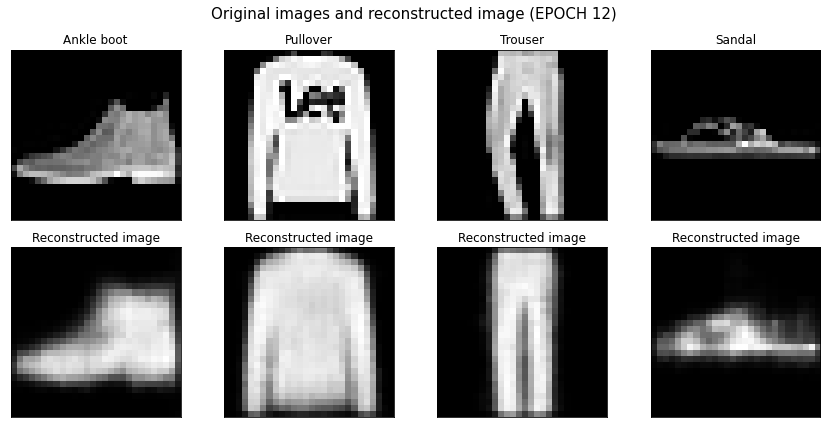

EPOCH 13/40
AVERAGE TRAIN LOSS: 0.029931502416729927
AVERAGE TEST LOSS: 0.0301891528069973


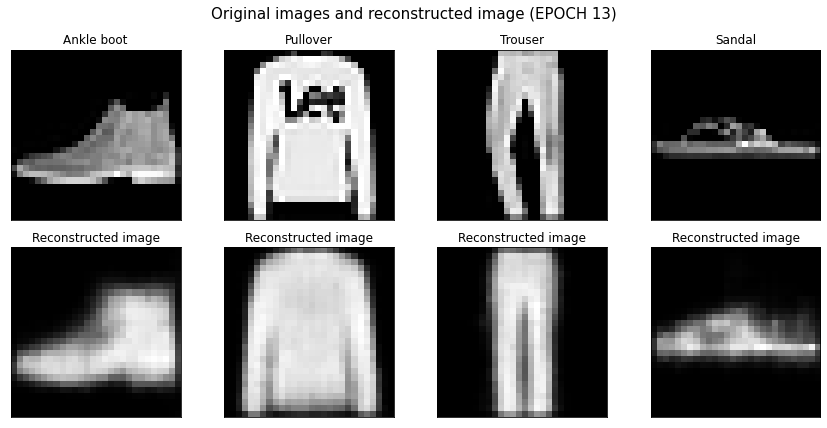

EPOCH 14/40
AVERAGE TRAIN LOSS: 0.029827214777469635
AVERAGE TEST LOSS: 0.029807358980178833


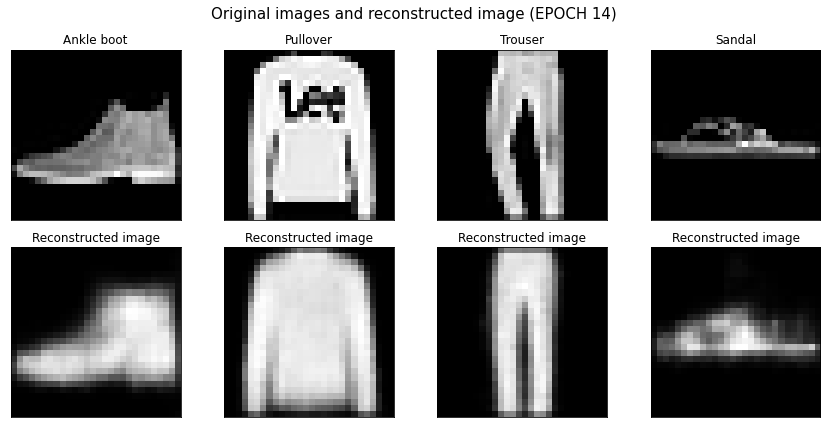

EPOCH 15/40
AVERAGE TRAIN LOSS: 0.029635660350322723
AVERAGE TEST LOSS: 0.029776960611343384


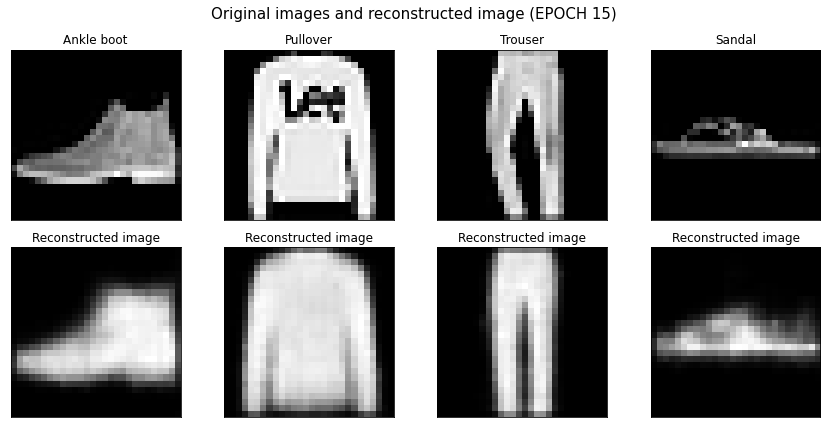

EPOCH 16/40
AVERAGE TRAIN LOSS: 0.02950386330485344
AVERAGE TEST LOSS: 0.029937852174043655


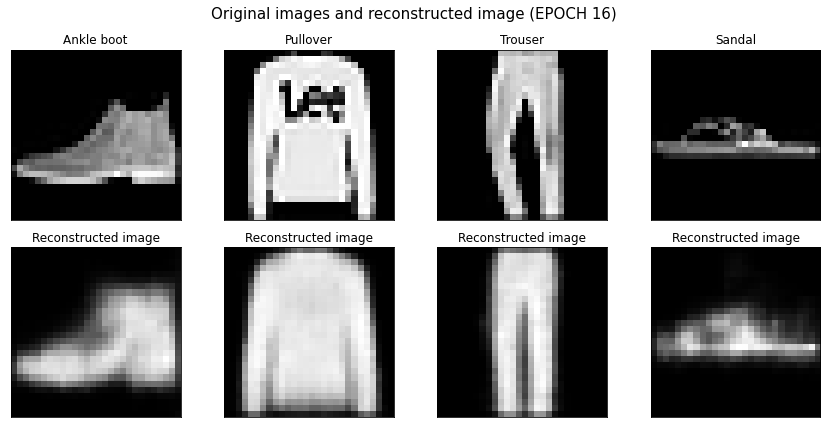

EPOCH 17/40
AVERAGE TRAIN LOSS: 0.02935396507382393
AVERAGE TEST LOSS: 0.029464561492204666


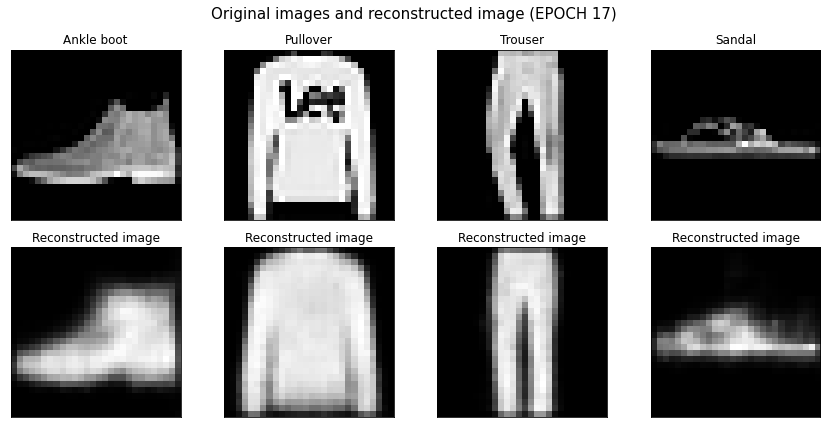

EPOCH 18/40
AVERAGE TRAIN LOSS: 0.029268531128764153
AVERAGE TEST LOSS: 0.02924511209130287


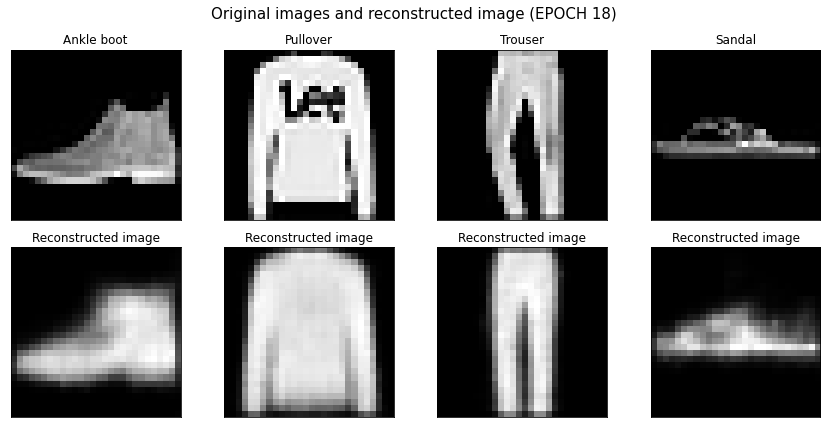

EPOCH 19/40
AVERAGE TRAIN LOSS: 0.029186585918068886
AVERAGE TEST LOSS: 0.029277056455612183


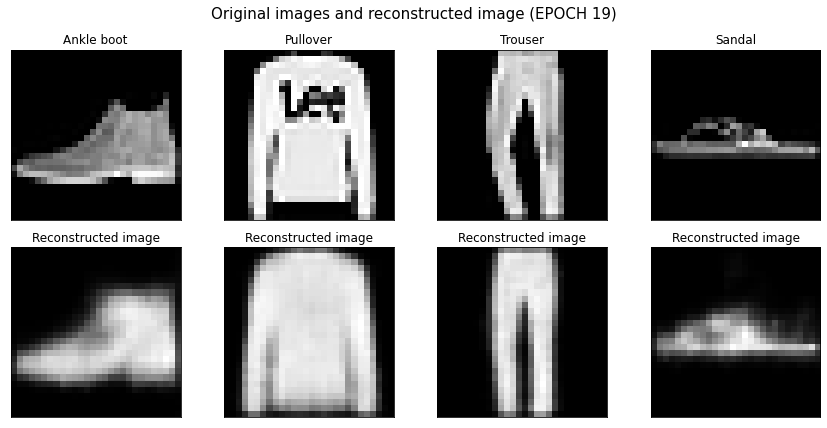

EPOCH 20/40
AVERAGE TRAIN LOSS: 0.029063772410154343
AVERAGE TEST LOSS: 0.029219454154372215


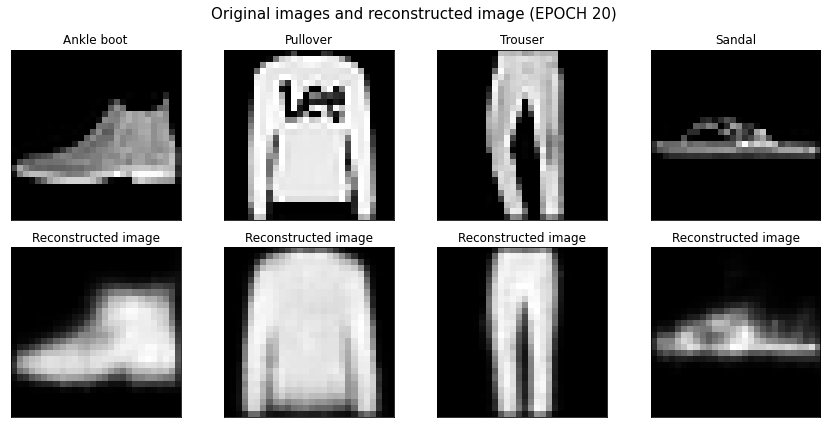

EPOCH 21/40
AVERAGE TRAIN LOSS: 0.029003847390413284
AVERAGE TEST LOSS: 0.029302095994353294


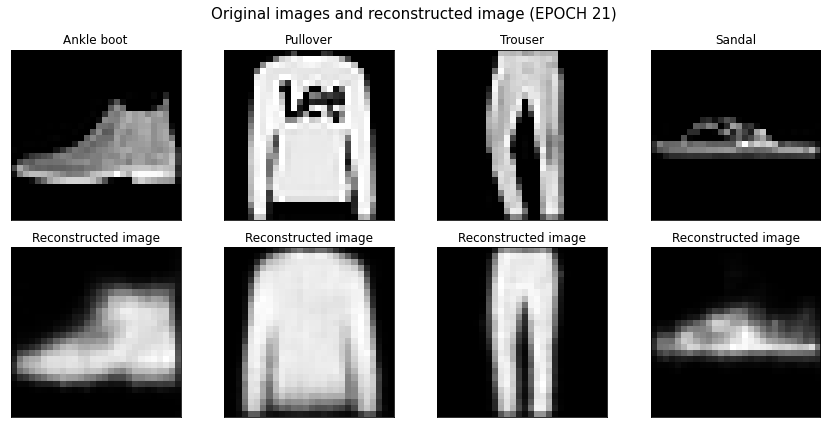

EPOCH 22/40
AVERAGE TRAIN LOSS: 0.028936734423041344
AVERAGE TEST LOSS: 0.02897113934159279


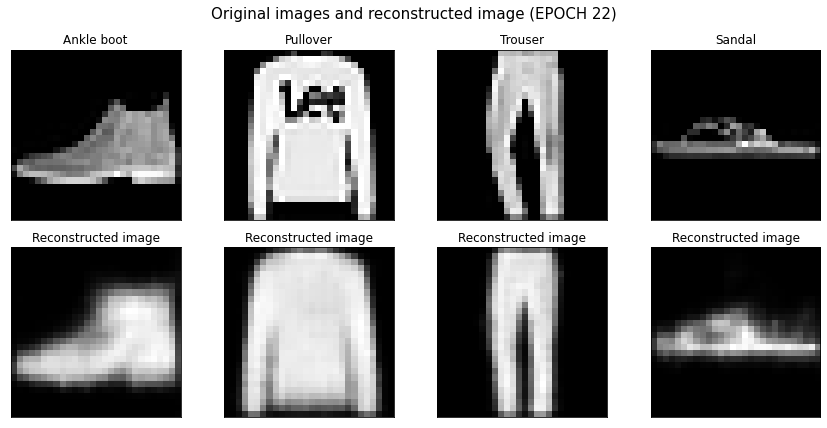

EPOCH 23/40
AVERAGE TRAIN LOSS: 0.028840109705924988
AVERAGE TEST LOSS: 0.02886049821972847


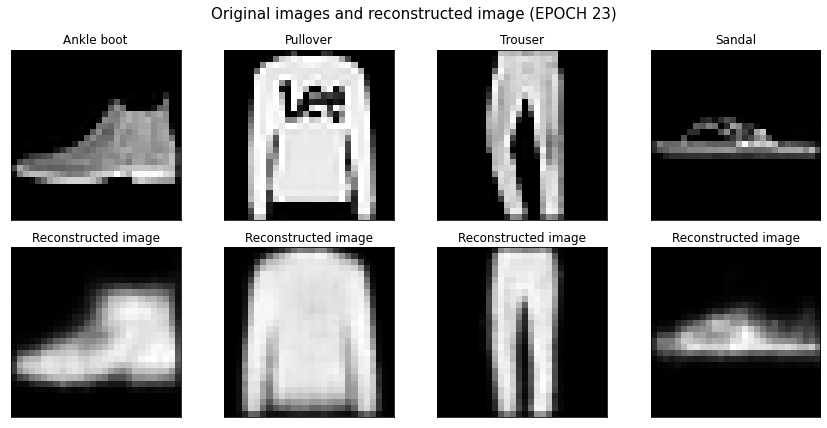

EPOCH 24/40
AVERAGE TRAIN LOSS: 0.02874852530658245
AVERAGE TEST LOSS: 0.028890833258628845


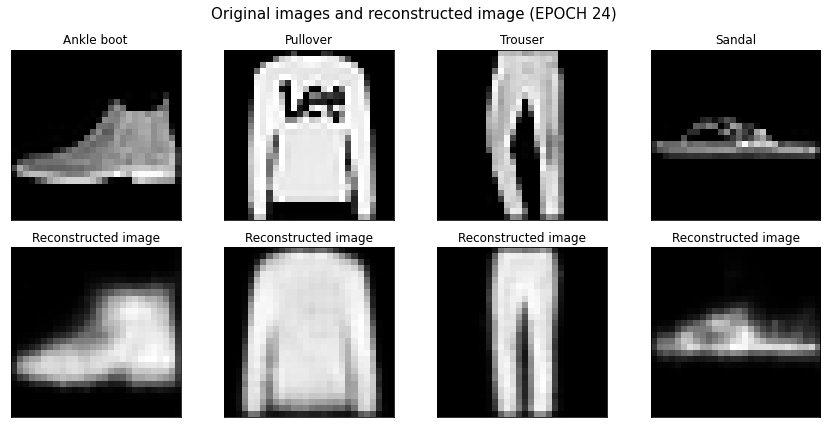

EPOCH 25/40
AVERAGE TRAIN LOSS: 0.02864903025329113
AVERAGE TEST LOSS: 0.028764421120285988


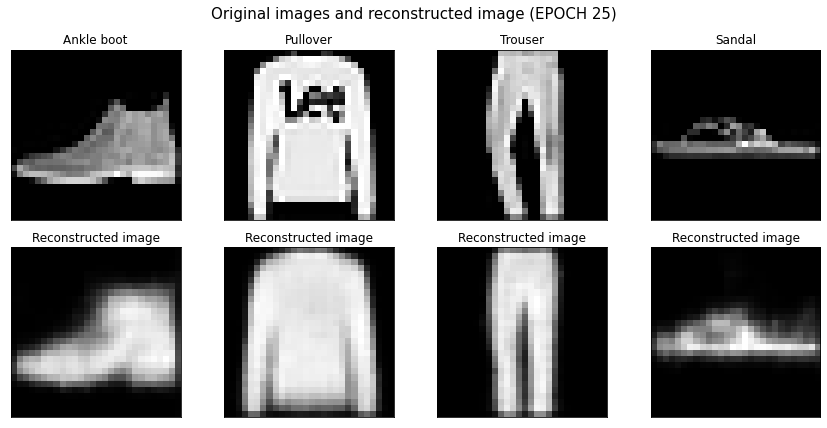

EPOCH 26/40
AVERAGE TRAIN LOSS: 0.028603840619325638
AVERAGE TEST LOSS: 0.02880368009209633


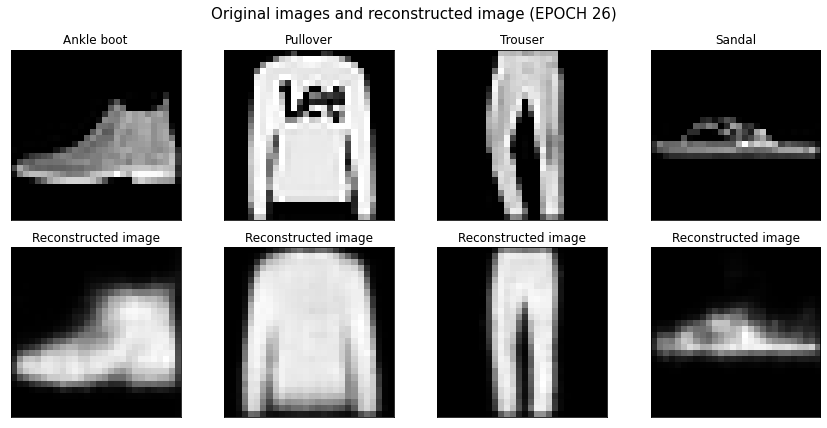

EPOCH 27/40
AVERAGE TRAIN LOSS: 0.02854927070438862
AVERAGE TEST LOSS: 0.028849666938185692


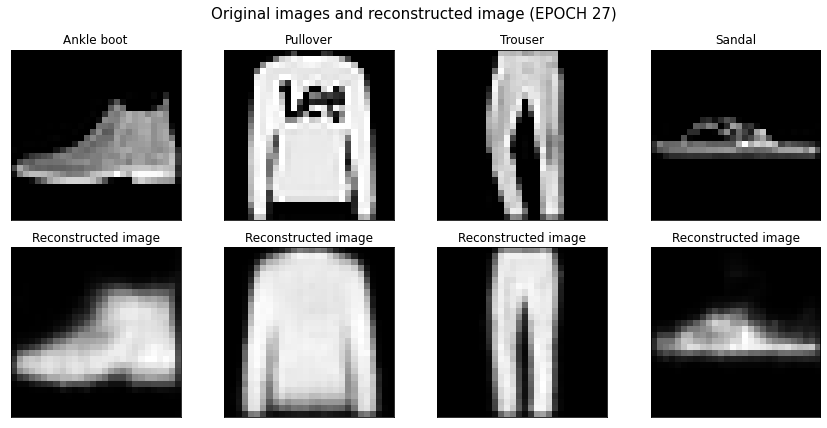

EPOCH 28/40
AVERAGE TRAIN LOSS: 0.028483841568231583
AVERAGE TEST LOSS: 0.028617721050977707


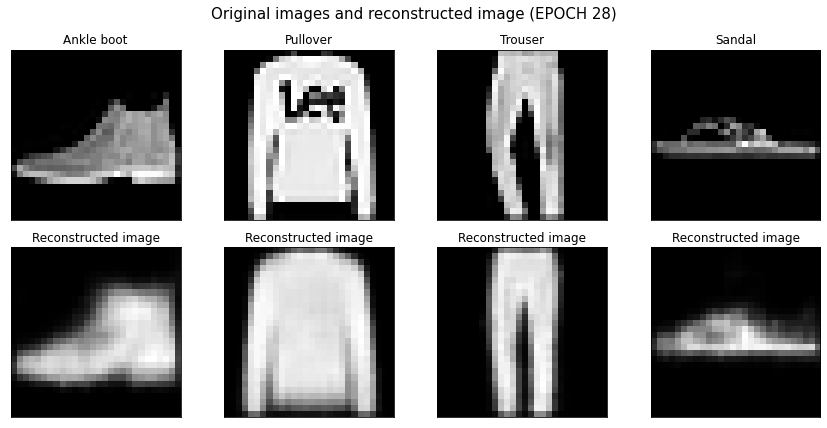

EPOCH 29/40
AVERAGE TRAIN LOSS: 0.028399625793099403
AVERAGE TEST LOSS: 0.028501298278570175


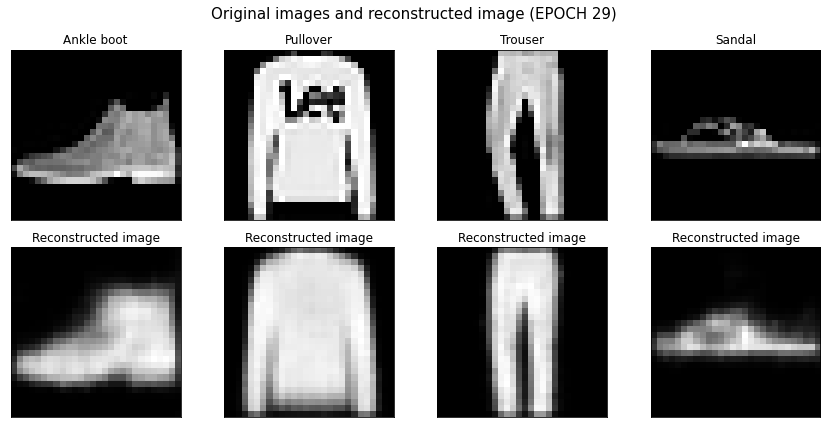

EPOCH 30/40
AVERAGE TRAIN LOSS: 0.02836671471595764
AVERAGE TEST LOSS: 0.0286850742995739


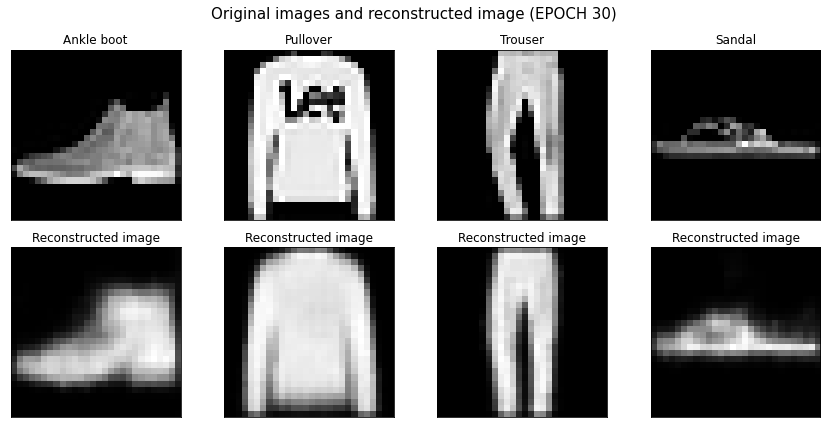

EPOCH 31/40
AVERAGE TRAIN LOSS: 0.028264978900551796
AVERAGE TEST LOSS: 0.028493409976363182


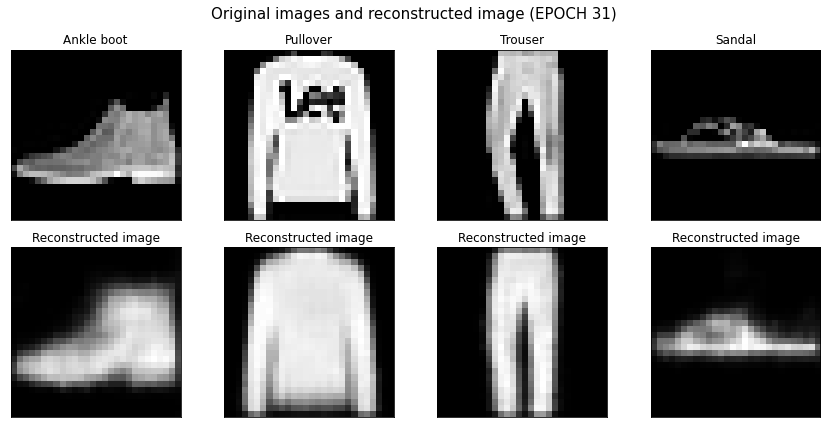

EPOCH 32/40
AVERAGE TRAIN LOSS: 0.02822001464664936
AVERAGE TEST LOSS: 0.028434257954359055


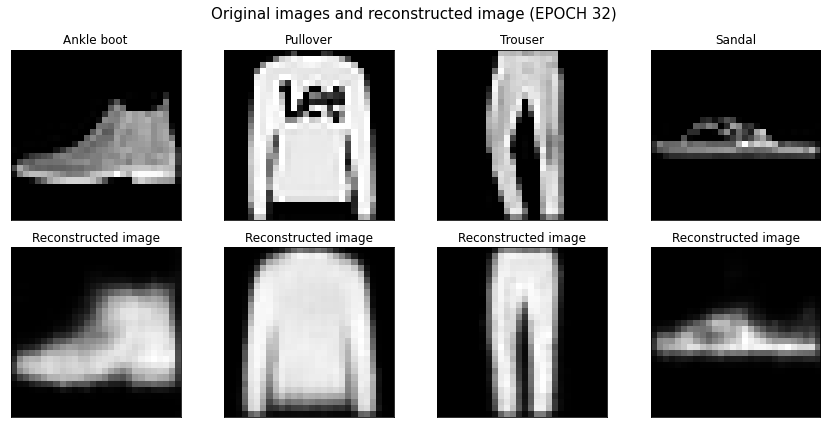

EPOCH 33/40
AVERAGE TRAIN LOSS: 0.028150882571935654
AVERAGE TEST LOSS: 0.028430327773094177


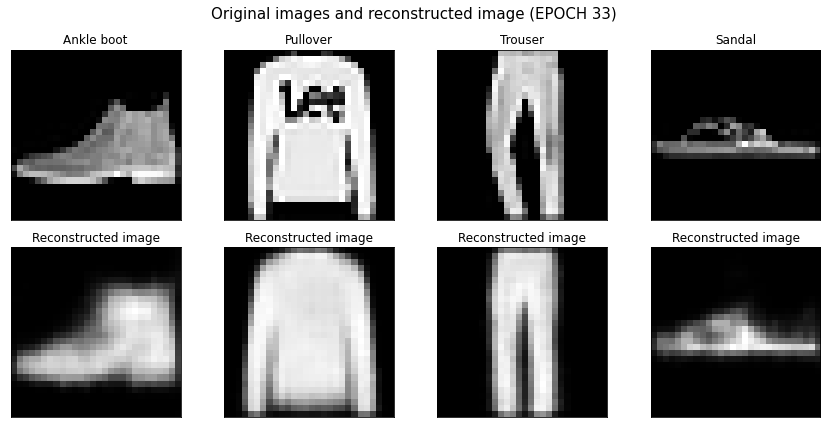

EPOCH 34/40
AVERAGE TRAIN LOSS: 0.028095602989196777
AVERAGE TEST LOSS: 0.028255213052034378


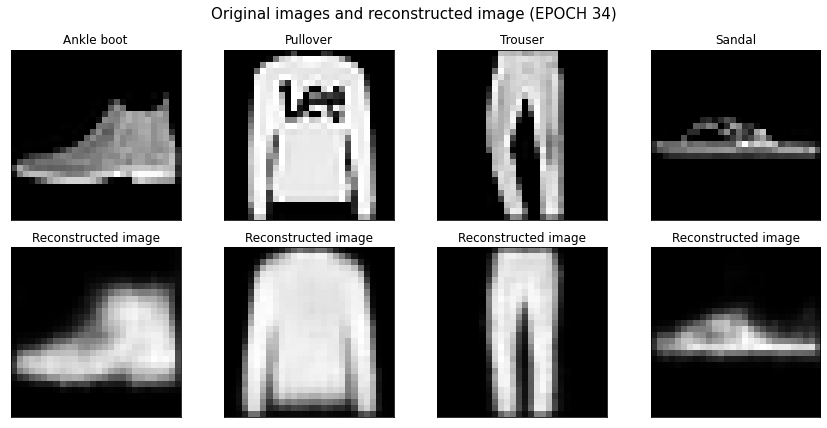

EPOCH 35/40
AVERAGE TRAIN LOSS: 0.02805190347135067
AVERAGE TEST LOSS: 0.02827569469809532


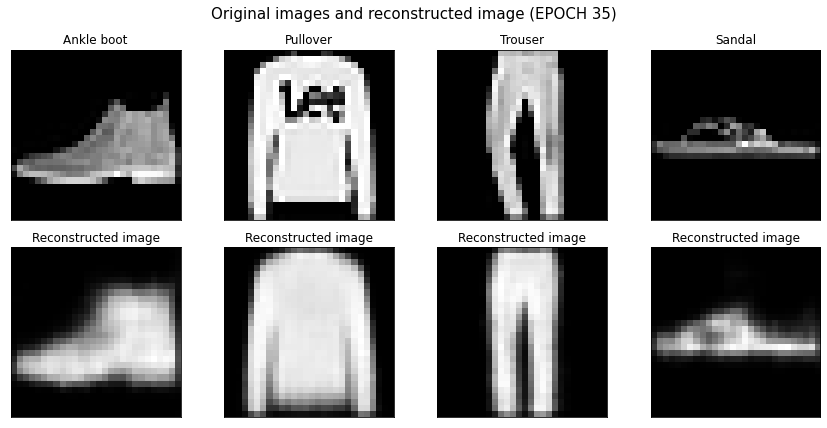

EPOCH 36/40
AVERAGE TRAIN LOSS: 0.027989760041236877
AVERAGE TEST LOSS: 0.028048163279891014


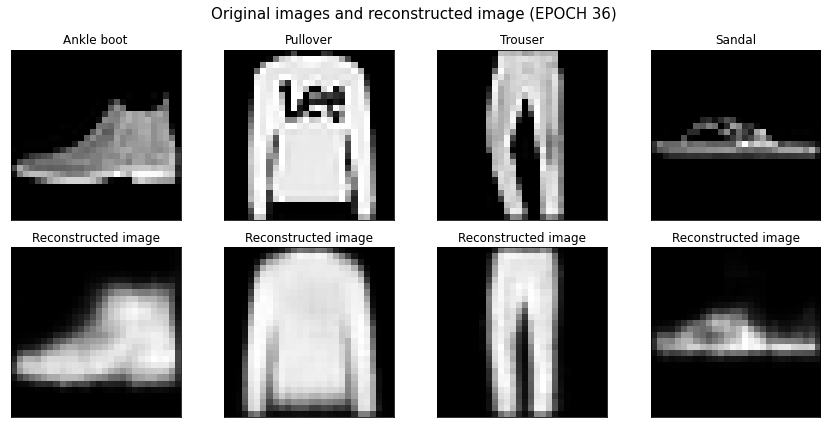

EPOCH 37/40
AVERAGE TRAIN LOSS: 0.027914760634303093
AVERAGE TEST LOSS: 0.02824315056204796


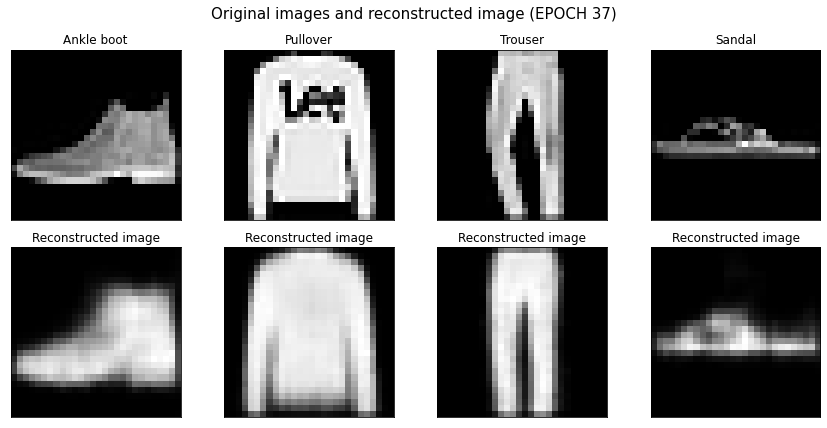

EPOCH 38/40
AVERAGE TRAIN LOSS: 0.027893703430891037
AVERAGE TEST LOSS: 0.02801693044602871


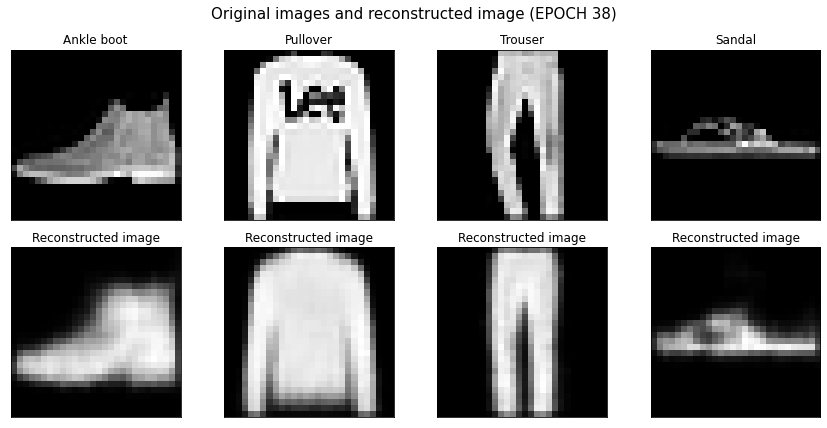

EPOCH 39/40
AVERAGE TRAIN LOSS: 0.027815967798233032
AVERAGE TEST LOSS: 0.028068095445632935


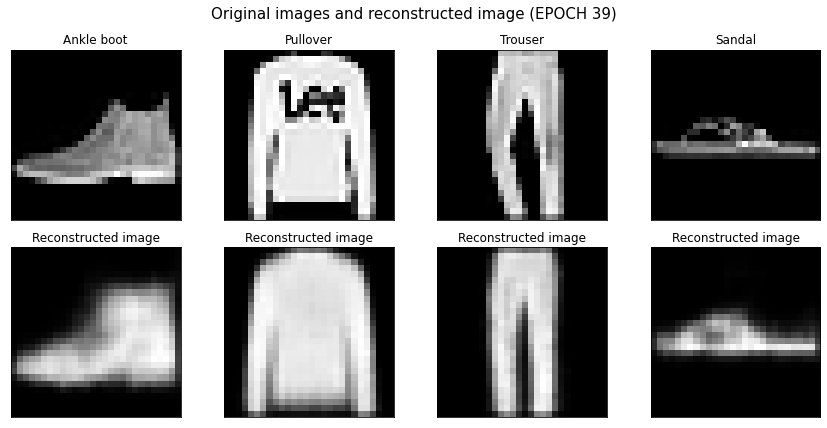

EPOCH 40/40
AVERAGE TRAIN LOSS: 0.027783185243606567
AVERAGE TEST LOSS: 0.027950424700975418


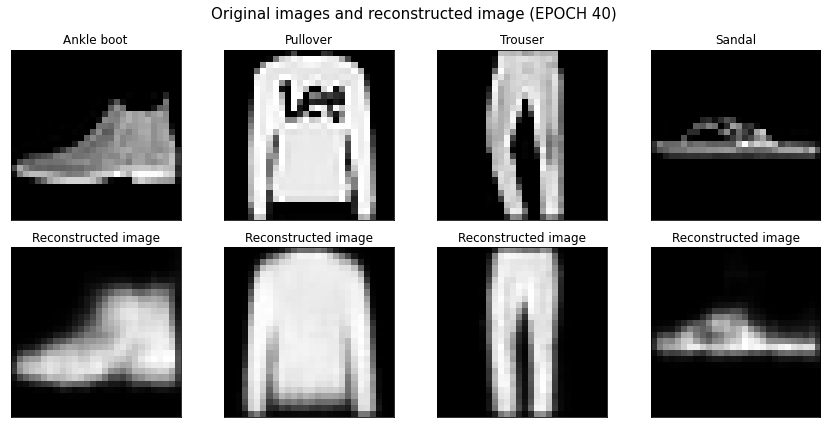

In [24]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=trial.params['lr'], weight_decay=1e-5)

###Train
train, test = training_cycle(encoder,
                             decoder,
                             device,
                             train_dataloader,
                             test_dataloader,
                             loss_fn,
                             optim,
                             40,
                             test_dataset,
                             plot=True)

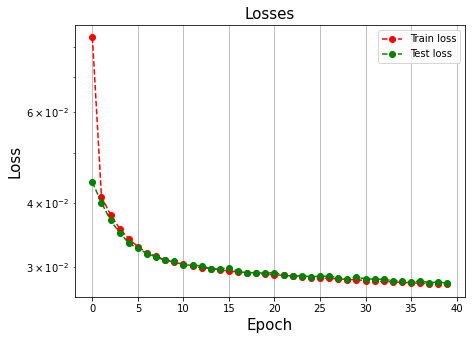

In [25]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.semilogy(train, linestyle='--', marker='o', color='r', label='Train loss')
plt.semilogy(test, linestyle='--', marker='o', color='g', label='Test loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.title("Losses",fontsize=15)
plt.grid()
plt.legend()
#plt.savefig('./imgs/classification/losses.svg', format='svg')
plt.show()

### Latent space exploration

### Convolutional autoencoder fine tuning  

[Fine-tuning vs transfer learning](https://stats.stackexchange.com/questions/343763/fine-tuning-vs-transferlearning-vs-learning-from-scratch#:~:text=Transfer%20learning%20is%20when%20a,the%20model%20with%20a%20dataset.)

[Transfer learning & fine-tuning Keras](https://keras.io/guides/transfer_learning/)

Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem. For instance, features from a model that has learned to identify racoons may be useful to kick-start a model meant to identify tanukis.

Transfer learning is usually done for tasks where your dataset has too little data to train a full-scale model from scratch.

The most common incarnation of transfer learning in the context of deep learning is the following workflow:

- Take layers from a previously trained model.
- Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
- Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
- Train the new layers on your dataset.

A last, optional step, is **fine-tuning**, which consists of unfreezing the entire model you obtained above (or part of it), and re-training it on the new data with a very low learning rate. This can potentially achieve meaningful improvements, by incrementally adapting the pretrained features to the new data.



[Transfer learning - Feature extraction vs fine tuning](https://cs231n.github.io/transfer-learning/)

[Transfer Learning - Machine Learning's Next Frontier](https://ruder.io/transfer-learning/)

Now we have a model that have learnt that there are different categories of elements (the encoder), so we could plug a new layer to the network and use it as a classifier of ten categories. The training will be performed under the supervised paradigm.

In [26]:
new_layer = nn.Linear(encoded_space_dim,10) #We go from our encoded space to the 10 categories

### Disable the weight update for the trained encoder
for param_name, param in encoder.named_parameters():
    param.requires_grad = False
    
### Allow weight update (training) of the last layers (linear layers)
for param in encoder.encoder_lin[0].parameters():
    param.requires_grad = True
    
for param in encoder.encoder_lin[2].parameters():
    param.requires_grad = True
    
### Check which weights and biases will be updated
for param_name, param in encoder.named_parameters():
    print(param_name,param.requires_grad)

encoder_cnn.0.weight False
encoder_cnn.0.bias False
encoder_cnn.2.weight False
encoder_cnn.2.bias False
encoder_cnn.4.weight False
encoder_cnn.4.bias False
encoder_lin.0.weight True
encoder_lin.0.bias True
encoder_lin.2.weight True
encoder_lin.2.bias True


In [27]:
# Move both the encoder and the new layer to the device
encoder.to(device)
new_layer.to(device)

Linear(in_features=2, out_features=10, bias=True)

Now we need to set the usual things for the training of a supervised model.
- split the training dataset into training and validation
- apply the transforms and define the dataloaders
- define training, validation functions and training loop
- TRAIN

In [28]:
#Define a validation dataset
train_percent = 0.7
n_train      = int(train_percent * len(train_dataset))
n_validation = len(train_dataset) - n_train
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [n_train, n_validation])

print('# of training samples  :',len(train_dataset))
print('# of validation samples:',len(val_dataset))
print('# of test samples      :',len(test_dataset))

# of training samples  : 42000
# of validation samples: 18000
# of test samples      : 10000


In [29]:
batch_size = 256
train_dataloader      = DataLoader(train_dataset,  batch_size=batch_size,        shuffle=True, num_workers=0)
validation_dataloader = DataLoader(val_dataset,    batch_size=len(val_dataset),  shuffle=False, num_workers=0)
test_dataloader       = DataLoader(test_dataset,   batch_size=len(test_dataset), shuffle=False, num_workers=0)

In [30]:
### Training function
def tune_train_epoch(encoder, new_layer, device,dataloader, loss_fn, optimizer):
    """
    This function train the network for one epoch
    """
    # Set train mode for both networks
    encoder.train()
    new_layer.train()
    
    # Train
    train_loss = []
    for x_batched, y_batched in dataloader:
        # Move data to device
        x_batched = x_batched.to(device)
        y_batched = y_batched.to(device)       
        # Encode the data
        z = encoder(x_batched)
        out = new_layer(z)
        # Compute loss
        loss = loss_fn(out, y_batched)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        #Updata weights
        optimizer.step()
        #Save trai loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)
    #Save the average train loss
    train_loss = np.mean(train_loss)
    print(f"AVERAGE TRAIN LOSS: {train_loss}")
    
    return train_loss

### Testing function
def tune_val_epoch(encoder, new_layer, device, dataloader, loss_fn):
    """
    This function test the network performance for one epoch of training
    """
    # Set evaluation mode for both networks
    encoder.eval()
    new_layer.eval()
    #
    val_loss = []
    # Discable gradient tracking
    with torch.no_grad():
        for x_batched, y_batched in dataloader:
            # Move data to device
            x_batched = x_batched.to(device)
            y_batched = y_batched.to(device)
            # Encode the data
            z   = encoder(x_batched)
            out = new_layer(z)
            # Compute loss
            loss = loss_fn(out, y_batched)
             #Save test loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)
        #Save the average train loss
        val_loss = np.mean(val_loss)
        print(f"AVERAGE VALIDATION LOSS: {val_loss}")
    
    return val_loss

In [31]:
def tune_training_cycle(encoder,new_layer,device,training_data, val_data, loss_fn, optim,num_epochs,test_dataset):
    """
    This function train the network for a desired number of epochs it also test the network 
    reconstruction performance and make plots comparing the input image and the reconstructed one.
    """
    #I keep track of losses for plots
    train_loss = []
    val_loss  = []
    for epoch in range(num_epochs):
        print('EPOCH %d/%d' % (epoch + 1, num_epochs))
        ### Training (use the training function)
        tr_l = tune_train_epoch(
            encoder=encoder, 
            new_layer=new_layer, 
            device=device, 
            dataloader=training_data, 
            loss_fn=loss_fn, 
            optimizer=optim)
        train_loss.append(tr_l)
        ### Validation  (use the testing function)
        v_l = tune_val_epoch(
            encoder=encoder, 
            new_layer=new_layer,  
            device=device, 
            dataloader=val_data, 
            loss_fn=loss_fn)
        val_loss.append(v_l)
        # Print Validationloss
        #print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, t_l))

    return train_loss, val_loss

In [32]:
### Define the loss function
loss_fn = nn.CrossEntropyLoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=1e-5, weight_decay=1e-5)

###Train
train, test = tune_training_cycle(encoder,
                             new_layer,
                             device,
                             train_dataloader,
                             validation_dataloader,
                             loss_fn,
                             optim,
                             60,
                             test_dataset)

EPOCH 1/60
AVERAGE TRAIN LOSS: 9.48879337310791
AVERAGE VALIDATION LOSS: 8.535449028015137
EPOCH 2/60
AVERAGE TRAIN LOSS: 7.685659408569336
AVERAGE VALIDATION LOSS: 6.904451847076416
EPOCH 3/60
AVERAGE TRAIN LOSS: 6.223320484161377
AVERAGE VALIDATION LOSS: 5.618926525115967
EPOCH 4/60
AVERAGE TRAIN LOSS: 5.101912975311279
AVERAGE VALIDATION LOSS: 4.651637077331543
EPOCH 5/60
AVERAGE TRAIN LOSS: 4.268955230712891
AVERAGE VALIDATION LOSS: 3.938328504562378
EPOCH 6/60
AVERAGE TRAIN LOSS: 3.6491565704345703
AVERAGE VALIDATION LOSS: 3.4050347805023193
EPOCH 7/60
AVERAGE TRAIN LOSS: 3.1855595111846924
AVERAGE VALIDATION LOSS: 3.009160280227661
EPOCH 8/60
AVERAGE TRAIN LOSS: 2.844555377960205
AVERAGE VALIDATION LOSS: 2.7172350883483887
EPOCH 9/60
AVERAGE TRAIN LOSS: 2.5952296257019043
AVERAGE VALIDATION LOSS: 2.5050864219665527
EPOCH 10/60
AVERAGE TRAIN LOSS: 2.416541337966919
AVERAGE VALIDATION LOSS: 2.35221004486084
EPOCH 11/60
AVERAGE TRAIN LOSS: 2.28403639793396
AVERAGE VALIDATION LOSS: 2

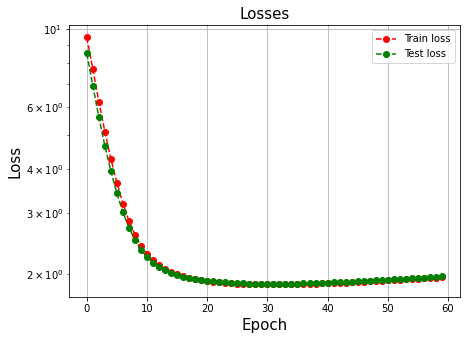

In [33]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.semilogy(train, linestyle='--', marker='o', color='r', label='Train loss')
plt.semilogy(test, linestyle='--', marker='o', color='g', label='Test loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.title("Losses",fontsize=15)
plt.grid()
plt.legend()
#plt.ylim(0,2)
#plt.savefig('./imgs/classification/losses.svg', format='svg')
plt.show()

Lets evaluate the acuracy on test set

In [34]:
test_acc = 0

y_test=[]
y_pred=[]

encoder.to(device)
#move the input to the GPU and predict the output
encoder.eval()
new_layer.eval()

with torch.no_grad():
    for x_batched, y_batched in test_dataloader:
        # Move data to device
        x_batched = x_batched.to(device)
        y_batched = y_batched.to(device)

        # Encode the data
        z   = encoder(x_batched)
        out = new_layer(z)

        y_test.append(y_batched)
        y_pred.append(out)

        pred = np.argmax(out.detach().cpu().numpy(), axis = 1)
        right = np.sum(pred == np.array(y_batched.cpu()))
        test_acc = test_acc + right

print(f"The obtained accuracy is {test_acc/len(test_dataset)*100} %")

The obtained accuracy is 33.82 %


# Variational Autoenconder, GAN or SimCLR 